### Data mining

In [1]:
import pandas as pd
import thinkplot
import thinkstats2
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

Read in data

In [2]:
df_raw = pd.read_csv('../../Data/ipums_2017.csv.zip')
df_raw.head()

,HHWT,REGION,STATEFIP,COUNTYFIP,METRO,MET2013,CITY,CITYERR,PUMA,CPUMA0010,...,DIFFHEAR,PWSTATE2,PWCOUNTY,PWMET13,PWTYPE,PWPUMA00,TRANWORK,TRANTIME,DEPARTS,ARRIVES
0,45,32,1,0,0,0,0,0,1800,13,...,0,1,117,13820,5,1200,10,50,642,734
1,136,32,1,0,0,0,0,0,2400,16,...,0,13,0,0,5,1700,10,45,1805,1849
2,19,32,1,0,0,0,0,0,2500,16,...,0,1,0,0,9,2500,10,25,717,744
3,21,32,1,0,0,0,0,0,500,2,...,0,1,0,0,9,290,10,60,602,704
4,21,32,1,0,0,0,0,0,500,2,...,0,1,0,0,9,290,10,85,702,829


In [3]:
work_force = df_raw[df_raw.EMPSTAT == 1] # Consider all employed people

Remove NaNs

In [4]:
work_force = work_force.dropna()
work_force.head()

,HHWT,REGION,STATEFIP,COUNTYFIP,METRO,MET2013,CITY,CITYERR,PUMA,CPUMA0010,...,DIFFHEAR,PWSTATE2,PWCOUNTY,PWMET13,PWTYPE,PWPUMA00,TRANWORK,TRANTIME,DEPARTS,ARRIVES
0,45,32,1,0,0,0,0,0,1800,13,...,0,1,117,13820,5,1200,10,50,642,734
1,136,32,1,0,0,0,0,0,2400,16,...,0,13,0,0,5,1700,10,45,1805,1849
2,19,32,1,0,0,0,0,0,2500,16,...,0,1,0,0,9,2500,10,25,717,744
3,21,32,1,0,0,0,0,0,500,2,...,0,1,0,0,9,290,10,60,602,704
4,21,32,1,0,0,0,0,0,500,2,...,0,1,0,0,9,290,10,85,702,829


Recode `SEX` to be 0 for female and 1 for male.

In [5]:
work_force['SEX'].replace(2, 0, inplace=True)
work_force['SEX'].value_counts()

1    775971
0    713015
Name: SEX, dtype: int64

In [6]:
# diff_vars = ['DIFFHEAR', 'DIFFPHYS', 'DIFFEYE', 'DIFFCARE', 'DIFFREM', 'DIFFMOB']
# work_force['DIFFHEAR'].replace(1, 0, inplace=True)
# work_force['DIFFPHYS'].replace(1, 0, inplace=True)
# work_force['DIFFEYE'].replace(1, 0, inplace=True)
# work_force['DIFFCARE'].replace(1, 0, inplace=True)
# work_force['DIFFREM'].replace(1, 0, inplace=True)
# work_force['DIFFMOB'].replace(1, 0, inplace=True)
# work_force['DIFFHEAR'].replace(2, 1, inplace=True)
# work_force['DIFFPHYS'].replace(2, 1, inplace=True)
# work_force['DIFFEYE'].replace(2, 1, inplace=True)
# work_force['DIFFCARE'].replace(2, 1, inplace=True)
# work_force['DIFFREM'].replace(2, 1, inplace=True)
# work_force['DIFFMOB'].replace(2, 1, inplace=True)
# work_force = work_force.drop(["INCEARN", "INCTOT", "OCCSCORE", "SEI", "OCC", "OCC1950", "DEGFIELD2D", "BIRTHYR", "RELATED", "PERNUM", "FERTYR", "DEGFIELD2D", "DEGFIELD2", "HISPAN", "GRADEATTD", "CLASSWKRD", "MET2013ERR", "GQ", "RACE", "CITYPOP", 'YEAR', 'DATANUM', 'SERIAL', 'CBSERIAL', 'COUNTYICP','STATEICP'], axis=1)
# work_force.to_csv("ipums_2017.csv", index=False)

Find hourly income using `UHRSWORK`, Usual hours worked per week, and `WKSWORK2`, Weeks worked last year (intervalled).

In [7]:
work_force = work_force[work_force['UHRSWORK'] >= 30] # Usual hours worked per week
work_force = work_force[work_force['WKSWORK2'] >= 3] # Weeks worked last year (level)

In [8]:
work_force['UHRSWORK'].replace([0], np.nan, inplace=True)
work_force['WKSWORK'] = work_force['WKSWORK2'].replace([0, 1, 2, 3, 4, 5, 6], [np.nan, 7, 20, 33, 43.5, 48.5, 51.5], inplace=False)
work_force['INCWAGE'].replace([0, 999999, 999998], np.nan, inplace=True)

In [9]:
work_force['HRLY_INCWAGE'] = work_force['INCWAGE']/(work_force['UHRSWORK'] * work_force['WKSWORK'])
work_force = work_force[work_force['HRLY_INCWAGE'] > 2] # Only consider those who earn > $2.0 hourly
work_force = work_force.dropna()

## Blinder–Oaxaca decomposition 

### Data cleaning

In [10]:
var_names_clean = ['DEGFIELDD', 'OCC2010', 'RACED', 'HISPAND', 'IND']
for col in var_names_clean:
    grouped = work_force.groupby(col)
    mean_income_by_group = grouped['HRLY_INCWAGE'].mean()
    mean_income_by_group = mean_income_by_group.sort_values(ascending=True)
    work_force[col].replace(mean_income_by_group.index, range(0, len(mean_income_by_group)), inplace=True)

### Decomposition

In [11]:
var_names = ['OCC2010', 'DEGFIELDD', 'IND', 'EDUCD', 'RACED']
var_describes = ['Occupation', 'Degree', 'Industry', 'Education', 'Race']

In [12]:
work_force['LOG_HRLY_INCWAGE'] = np.log(work_force['HRLY_INCWAGE'])
work_force['LOG_HRLY_INCWAGE'].head()

0    2.879162
1    3.505170
2    2.455348
3    3.046216
4    3.320345
Name: LOG_HRLY_INCWAGE, dtype: float64

In [13]:
men = work_force[work_force['SEX']==1]
women = work_force[work_force['SEX']==0]

In [21]:
men['EDUC'].mean()

7.715338317283325

In [16]:
# Build formula
formula = 'LOG_HRLY_INCWAGE ~ '
for col in var_names:
    formula += col + ' + '
    
formula = formula[:-3]
formula

'LOG_HRLY_INCWAGE ~ OCC2010 + DEGFIELDD + IND + EDUCD + RACED'

In [17]:
model_men = smf.ols(formula, data=men)
results_men = model_men.fit()
results_men.params

Intercept    2.037154
OCC2010      0.001937
DEGFIELDD    0.001610
IND          0.001576
EDUCD        0.002842
RACED        0.001386
dtype: float64

In [18]:
paygap = men['LOG_HRLY_INCWAGE'].mean() - women['LOG_HRLY_INCWAGE'].mean()
paygap

0.19071339396223674

In [19]:
explained = 0
results = []
for i, var in enumerate(var_names):
    mean_male = men[var].mean()
    mean_female = women[var].mean()
    coef = results_men.params[var]
    percent = coef*(mean_male-mean_female)/paygap*100
    explained += percent
    results.append(dict(var=var,var_describe=var_describes[i],percent=percent))
    print(var, percent)
    
explained

OCC2010 21.012544886546443
DEGFIELDD 4.634474548099807
IND 2.0340743140104007
EDUCD -5.771433329796493
RACED 1.0732716288442947


22.982932047704452

In [20]:
explained

22.982932047704452

In [21]:
unexplained = 100 - explained
unexplained

77.01706795229555

### Plot results

In [22]:
# pip install plotly --upgrade
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff

plotly.offline.init_notebook_mode(connected=True)
def plotExplainedResults(results):
    data = []
    explained = 0
    for i, r in enumerate(results):
        var, var_describe, percent = r.get('var'), r.get('var_describe'), r.get('percent')
        
        data.append(dict(Task=var_describe, Start=explained, Finish=explained+percent, Resource=('Plus' if percent > 0 else 'Minus')))
        if i <= len(results) - 2:
            data.append(dict(Task=results[i+1].get('var_describe'), Start=0, Finish=explained+percent, Resource='Explained'))
        explained += percent;
    
    data.append(dict(Task='Total', Start=0, Finish=explained, Resource='Explained'))
    data.append(dict(Task='Total', Start=explained, Finish=100, Resource='Unexplained'))
    
    df = [data[i] for i in range(10)]

    colors = {'Plus':'rgb(13, 71, 161)',
              'Explained': 'rgb(0, 153, 204)',
              'Minus': 'rgb(204, 0, 0)',
              'Unexplained': 'rgb(62, 69, 81)'}

    fig = ff.create_gantt(df, colors=colors, index_col='Resource', show_colorbar=True, group_tasks=True, 
                          bar_width=0.4, title = "What factors contribute to the gender pay gap?",
                         showgrid_x=True, showgrid_y=True,)
    fig['layout']['xaxis'].update({'type': None, 'title':'Percent'})
    fig['layout']['annotations'] = tuple([dict(x=(data[8]['Finish']+data[8]['Start'])/2-0.5,y=1,text="+1.1%",showarrow=False,font=dict(color='white')),
                                         dict(x=(data[6]['Finish']+data[6]['Start'])/2,y=2,text="-5.6%",showarrow=False,font=dict(color='white')),
                                         dict(x=(data[4]['Finish']+data[4]['Start'])/2,y=3,text="+2%",showarrow=False,font=dict(color='white')),
                                         dict(x=(data[2]['Finish']+data[2]['Start'])/2,y=4,text="+4.6%",showarrow=False,font=dict(color='white')),
                                         dict(x=(data[0]['Finish']+data[0]['Start'])/2,y=5,text="+21%",showarrow=False,font=dict(color='white')),
                                         dict(x=(data[9]['Finish']+data[9]['Start'])/2,y=0,text="+23%",showarrow=False,font=dict(color='white'))])
    plotly.offline.iplot(fig)

In [23]:
plotExplainedResults(results)

### Predictive powers

#### Find variables that impact income the most

In [24]:
t = []
for name in work_force.columns:
    try:
        if work_force[name].var() < 1e-7:
            continue
        
        formula = 'HRLY_INCWAGE ~ ' + name
        model = smf.ols(formula, data=work_force)
        if model.nobs < len(work_force)/2:
            print(model.nobs)
            continue
            
        results = model.fit()
    except (ValueError, TypeError):
        continue
        
    t.append((results.rsquared, name))

In [25]:
t.sort(reverse=True)
for r2, name in t[:-1]:
    print(name, r2)

HRLY_INCWAGE 1.0
INCWAGE 0.9261158455252794
LOG_HRLY_INCWAGE 0.6795926222387931
OCC2010 0.19075047050446503
DEGFIELDD 0.15212340898873777
EDUCD 0.12075577248421288
EDUC 0.11627210702436874
IND 0.10144256078893521
DEGFIELD 0.0951023297375887
MARST 0.03760606125612209
AGE 0.033228751535220535
YRMARR 0.029945658063642355
RELATE 0.020329427202418704
RACED 0.01831551883196203
SEX 0.015630218428316134
HISPAND 0.013629126114410361
PWTYPE 0.01251682703960788
MET2013 0.011530645300390496
PWMET13 0.009299384416518786
METRO 0.008828651596018644
UHRSWORK 0.00791208831388257
CLASSWKR 0.007129525815958382
ELDCH 0.006770865948471982
YNGCH 0.0065225018143909574
SCHOOL 0.005137271811117117
NCHILD 0.005116032233183243
TRANTIME 0.004794247453699718
TRANWORK 0.004597630200731451
GRADEATT 0.004542730040963949
DEPARTS 0.00403277062846652
SCHLTYPE 0.003703717214444957
NFAMS 0.003657922426603011
PERWT 0.0030467392110153924
HOMELAND 0.0029909009135372644
ARRIVES 0.002971371832194536
WKSWORK 0.00248696863027120

#### Income ~ variables

In [26]:
# Build formula
formula = 'HRLY_INCWAGE ~ '
ignores = ['HRLY_INCWAGE', 'SEX', 'UHRSWORK', 'WKSWORK2', 'WKSWORK', 'INCWAGE', 'INCEARN', 'INCTOT', 'OCCSCORE', 'SEI', 'SERIAL', 'CBSERIAL', 'GQ', 'PERNUM', 'PERWT', 'HHWT', 'RACE', 'HISPAN', 'EDUC', 'DEGFIELD2', 'EMPSTATD', 'HRLY_INCWAGE']
for col in work_force.columns:
    try:
        if work_force[col].var() < 1e-7 or col in ignores:
            continue

        formula += name + ' + '

    except (ValueError, TypeError):
        continue

In [27]:
formula = formula[:-3]
formula

'HRLY_INCWAGE ~ CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN + CITIZEN'

In [28]:
model = smf.ols(formula, data=work_force)
results = model.fit()
results.rsquared

4.084680560234588e-05

#### Income ~ variables + sex

In [29]:
formula_sex = formula + ' + SEX'

In [30]:
model = smf.ols(formula_sex, data=work_force)
results = model.fit()
results.rsquared

0.015751233097645256

Men earns $10 more hourly than women on average.

In [31]:
results.params['SEX']

6.964676474245737

In [32]:
male = work_force[work_force['SEX'] == 1]
female = work_force[work_force['SEX'] == 0]

In [33]:
male['HRLY_INCWAGE'].mean() - female['HRLY_INCWAGE'].mean()

6.942175757895772

### Analysis into some variables

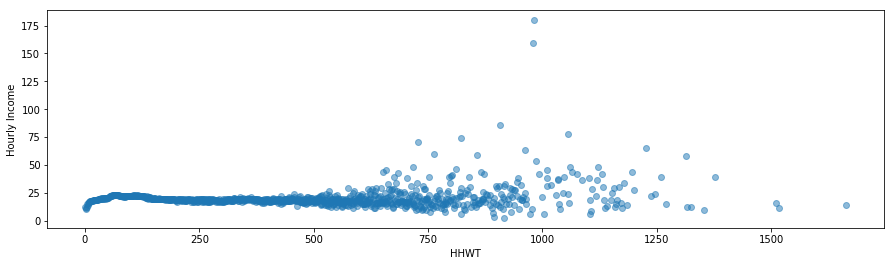

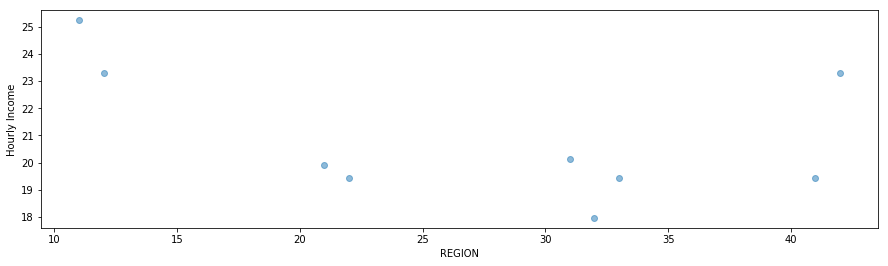

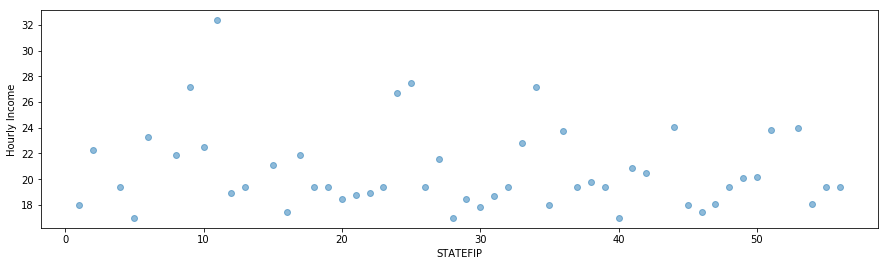

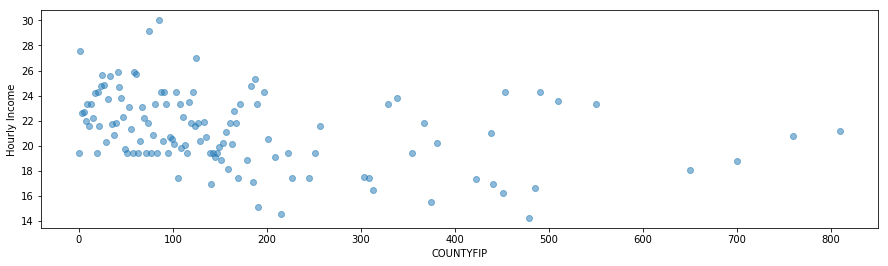

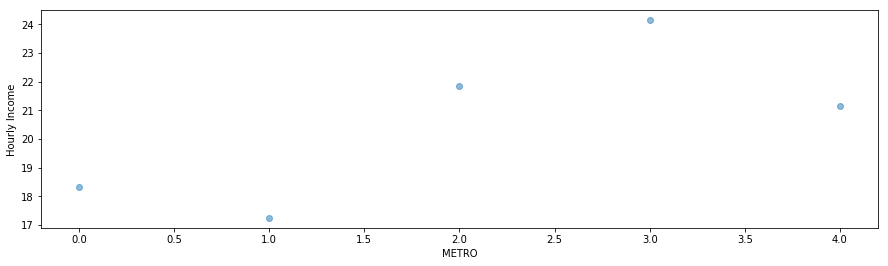

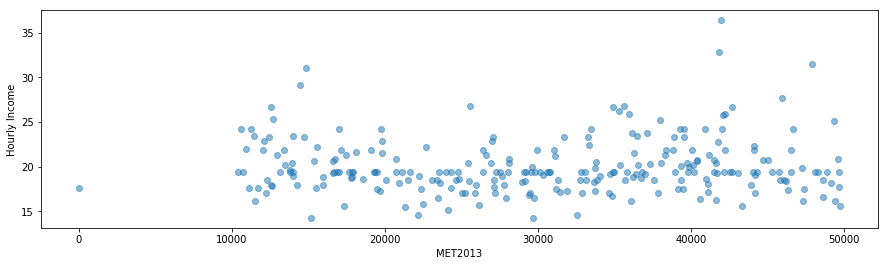

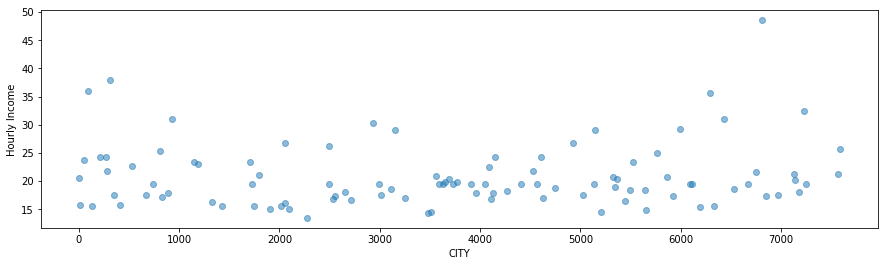

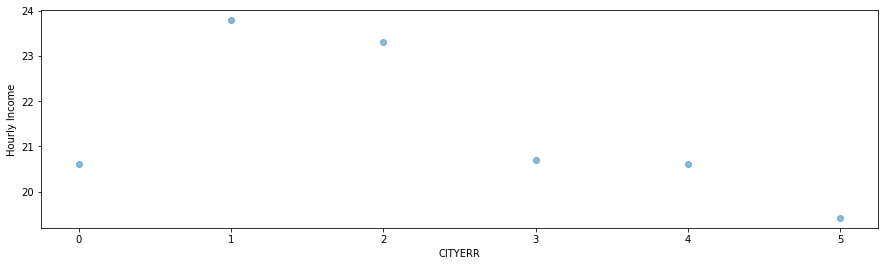

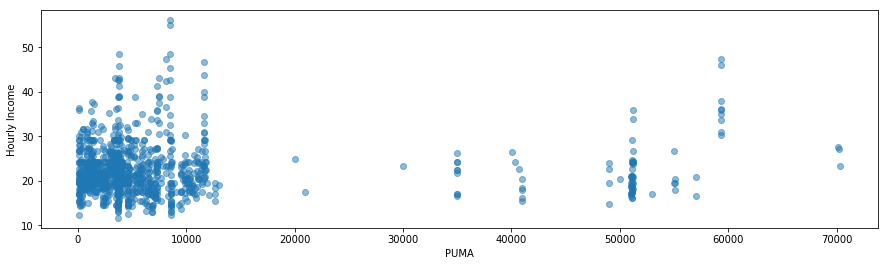

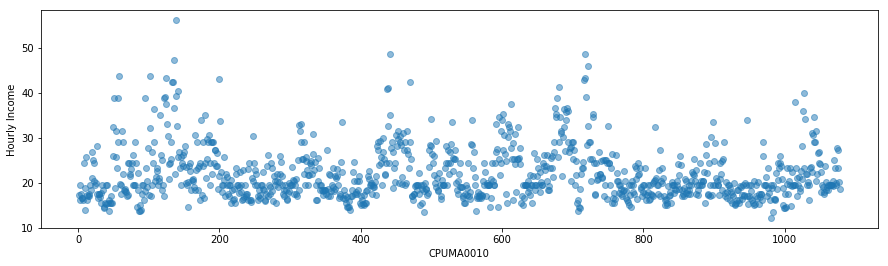

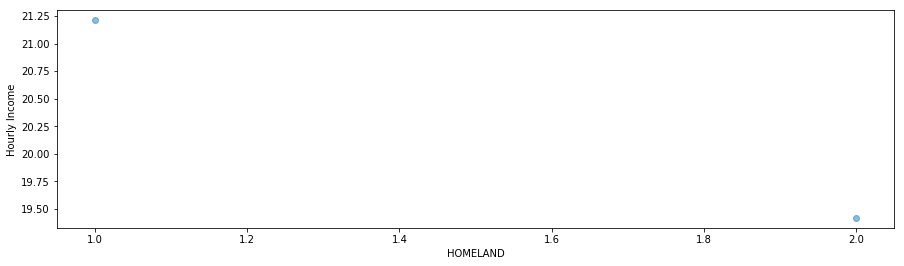

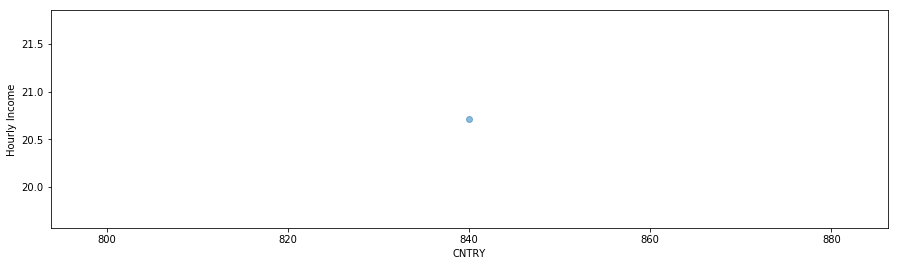

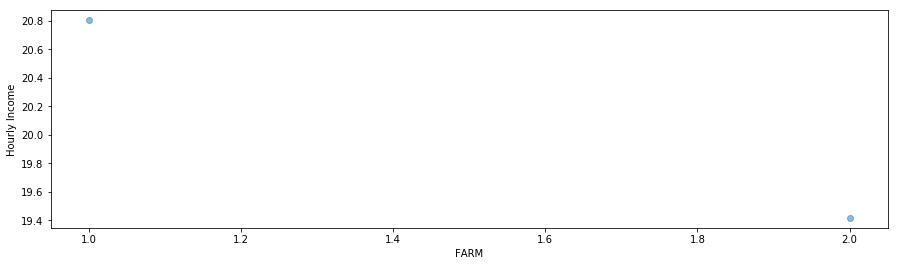

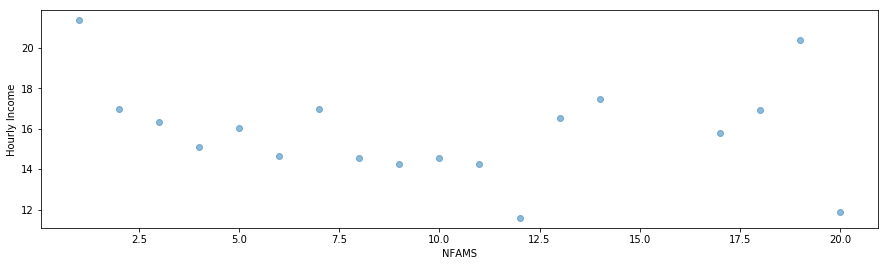

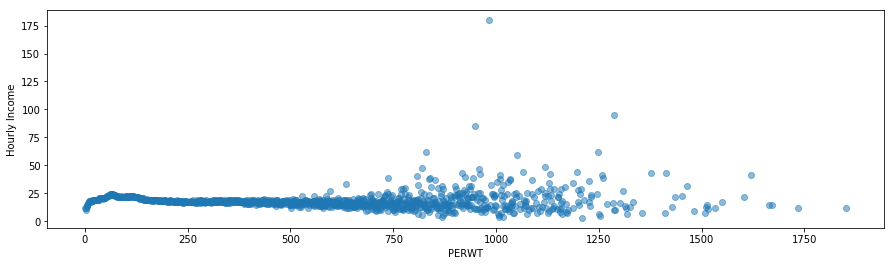

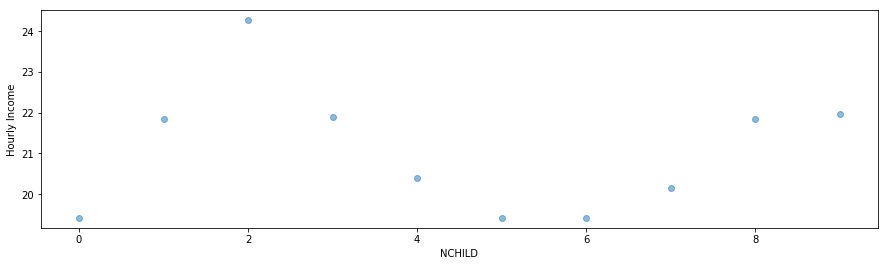

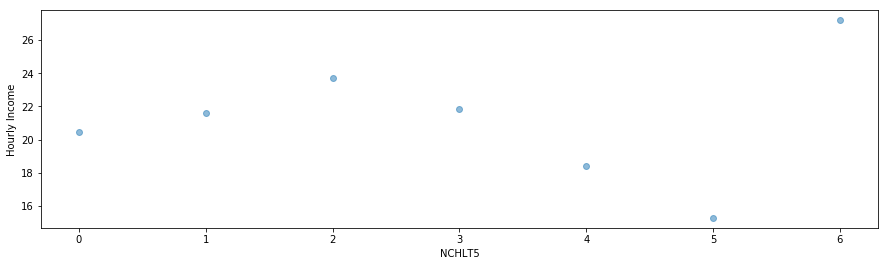

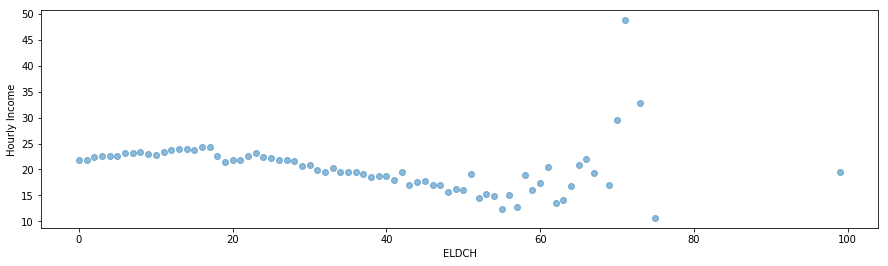

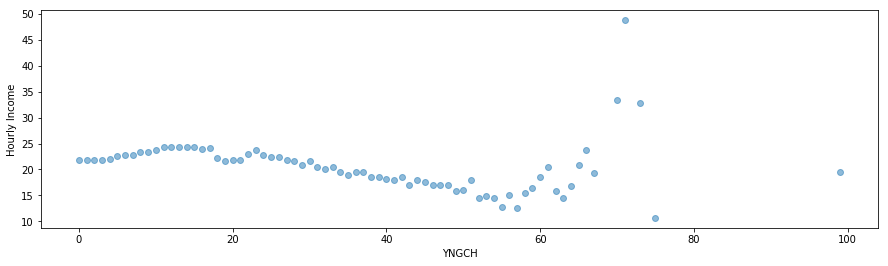

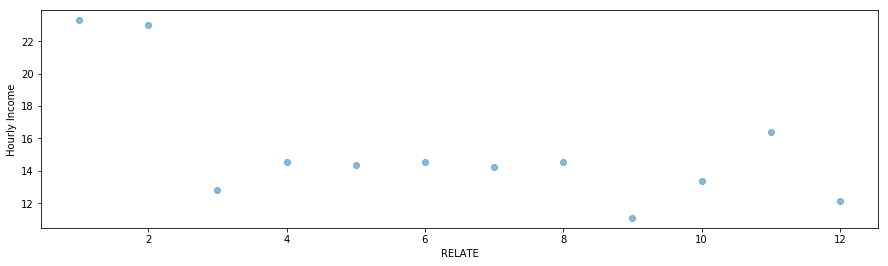

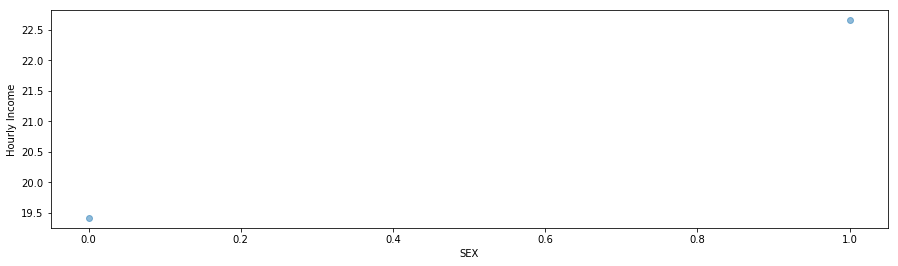

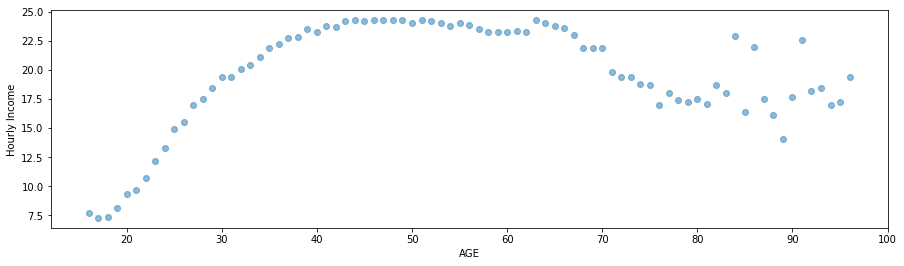

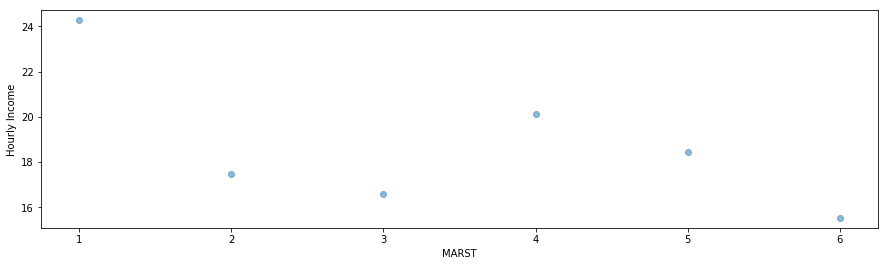

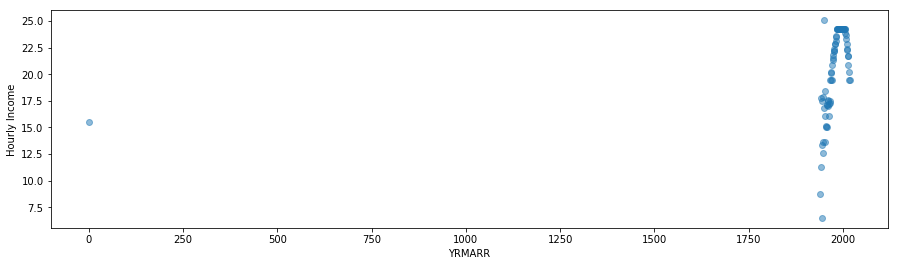

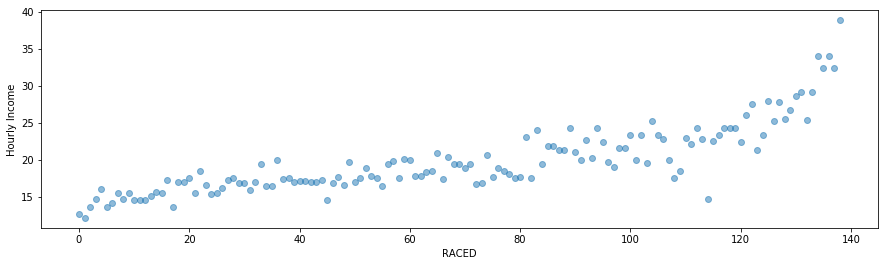

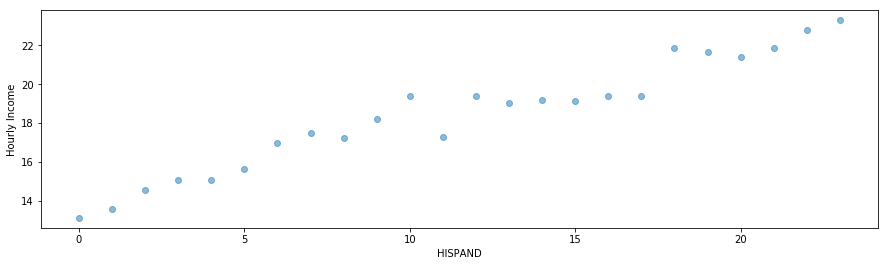

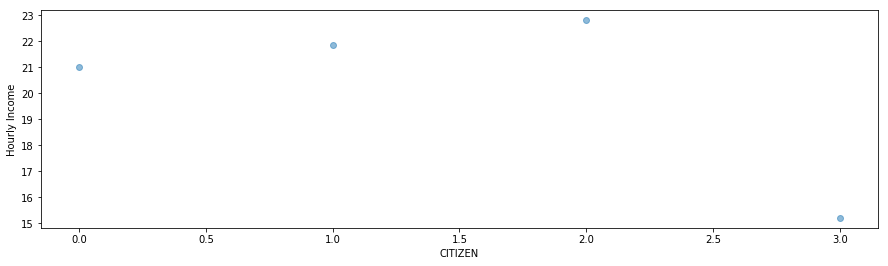

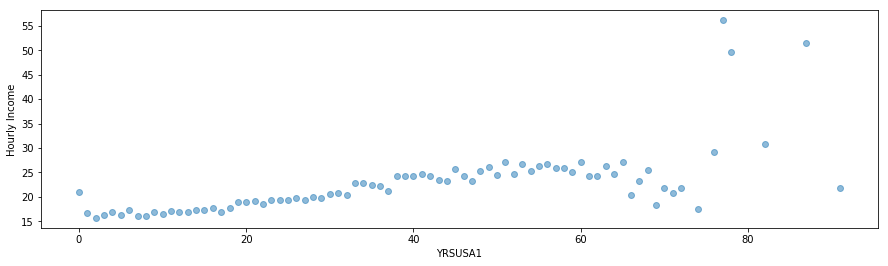

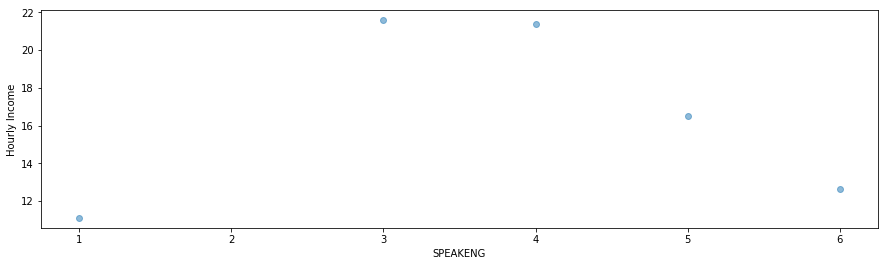

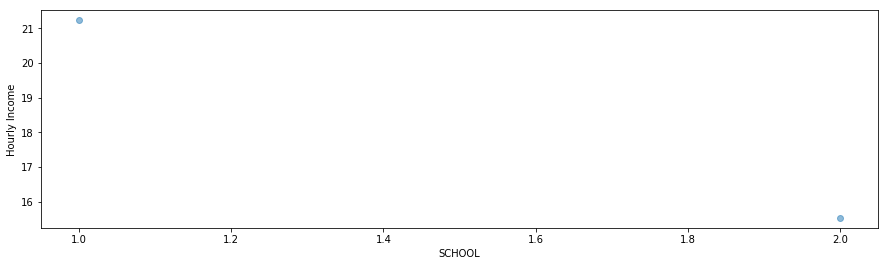

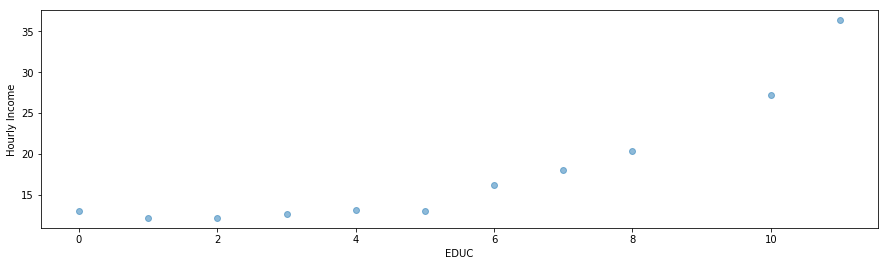

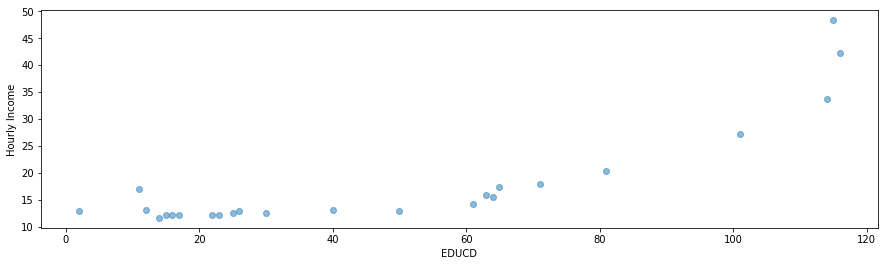

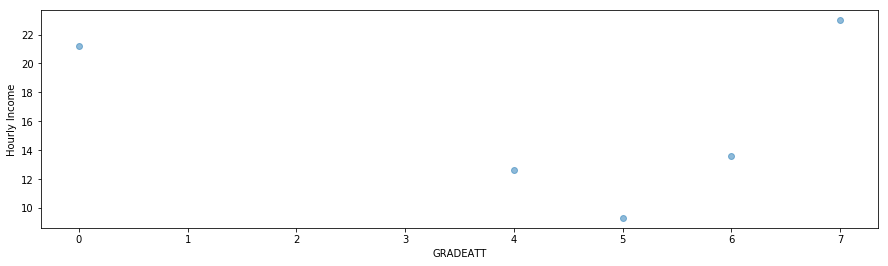

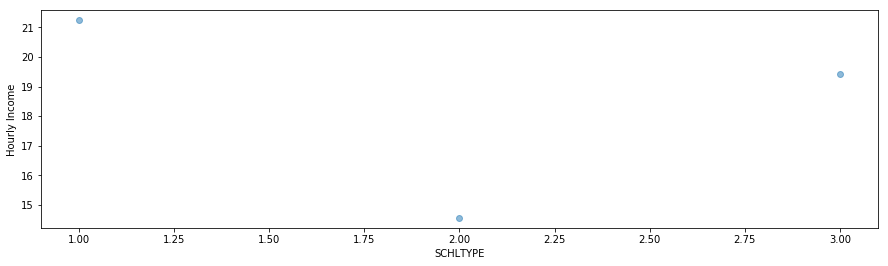

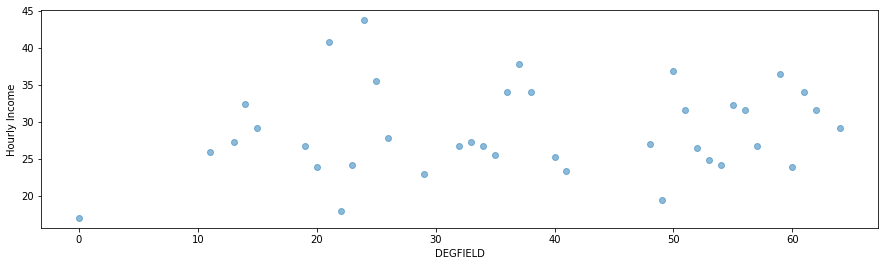

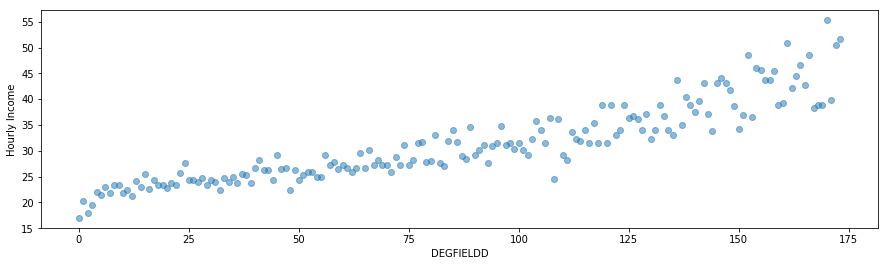

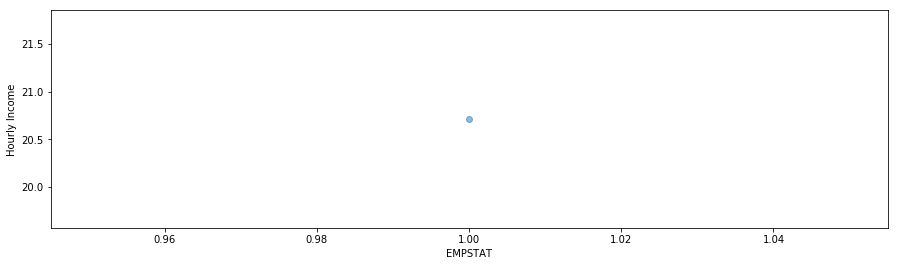

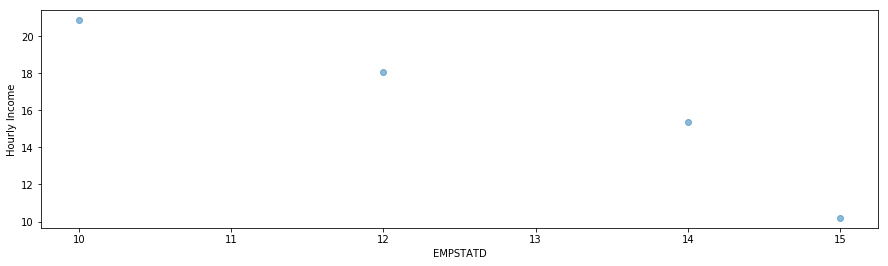

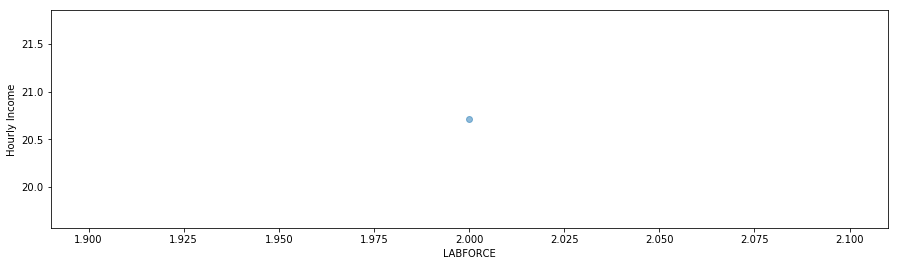

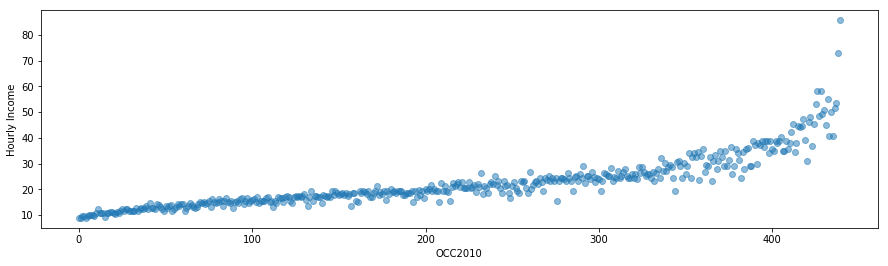

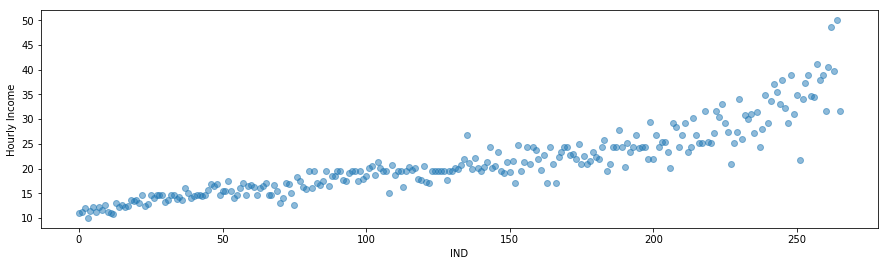

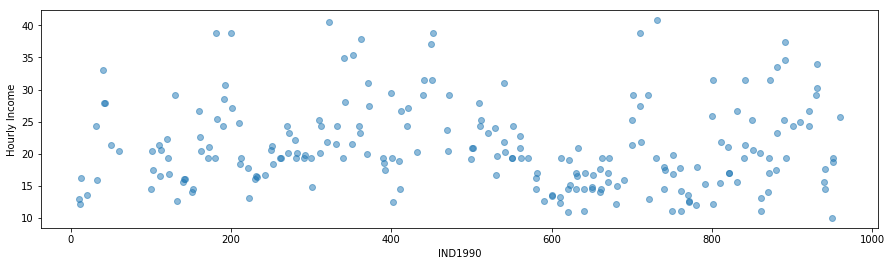

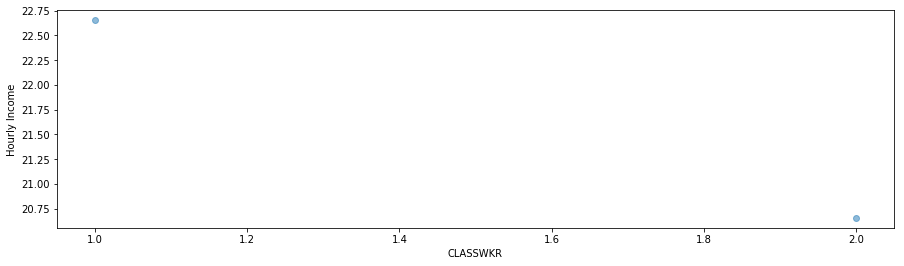

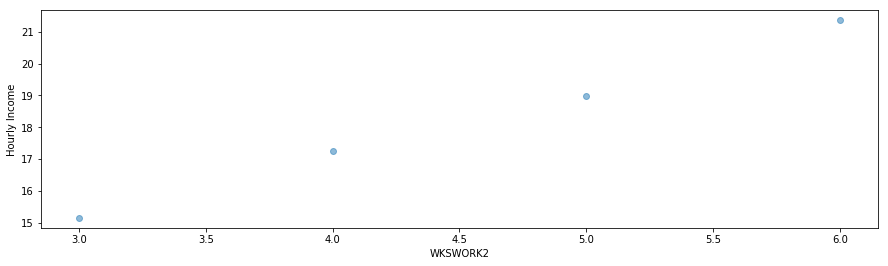

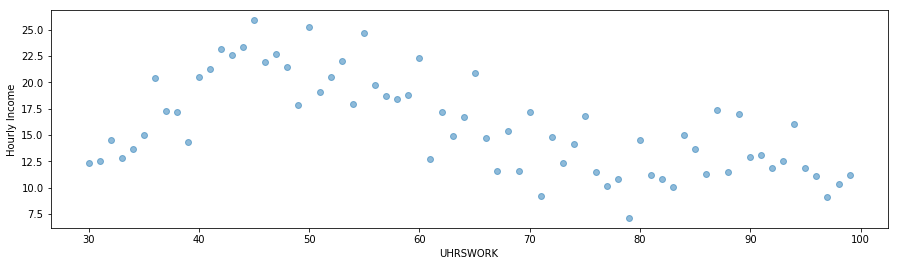

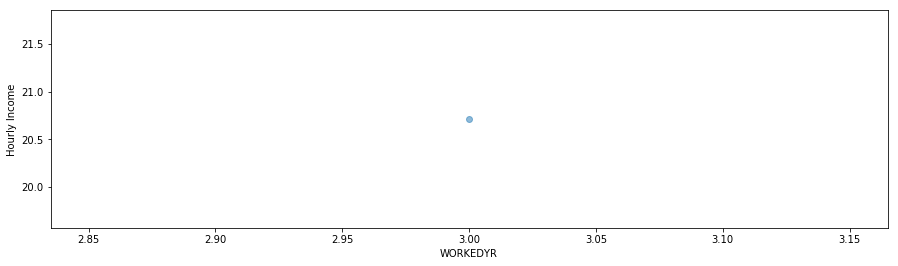

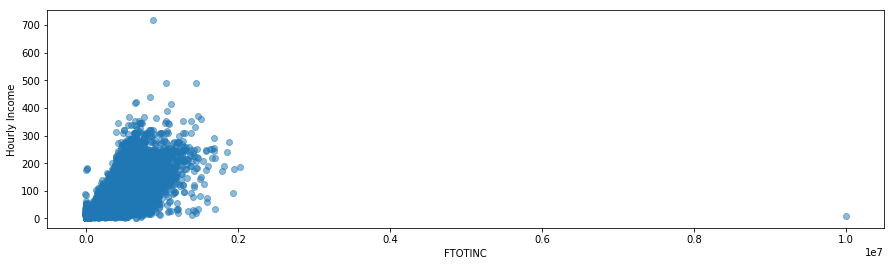

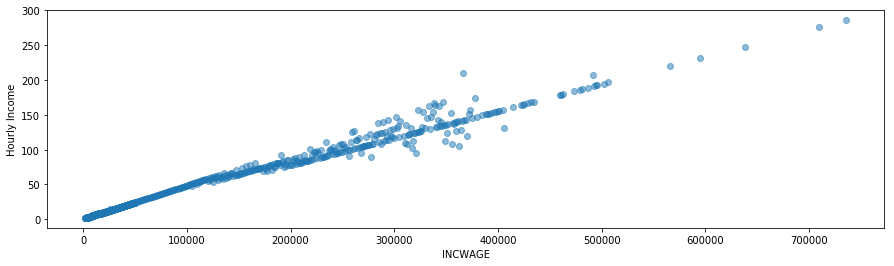

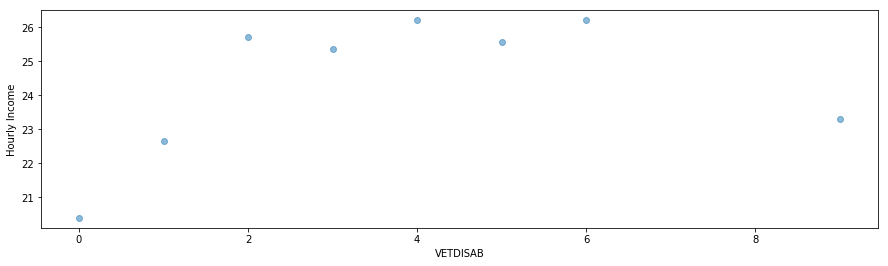

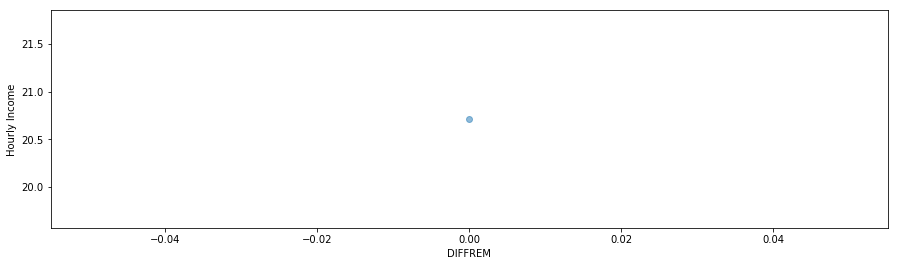

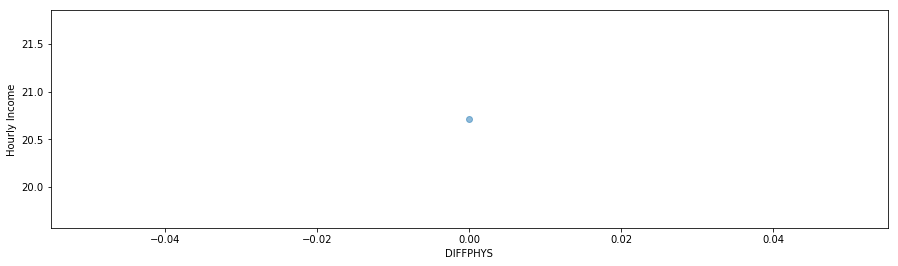

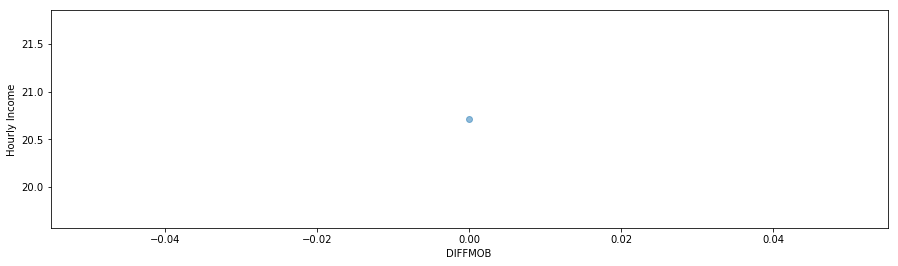

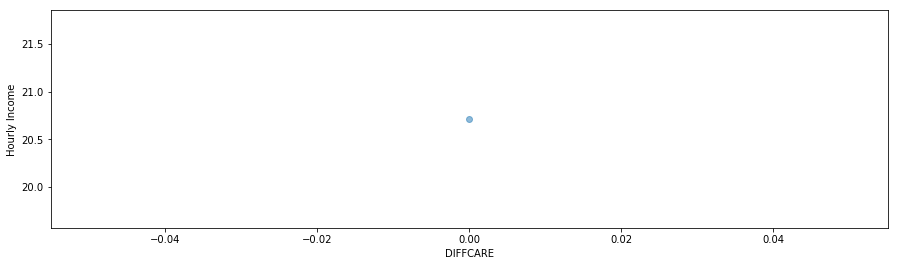

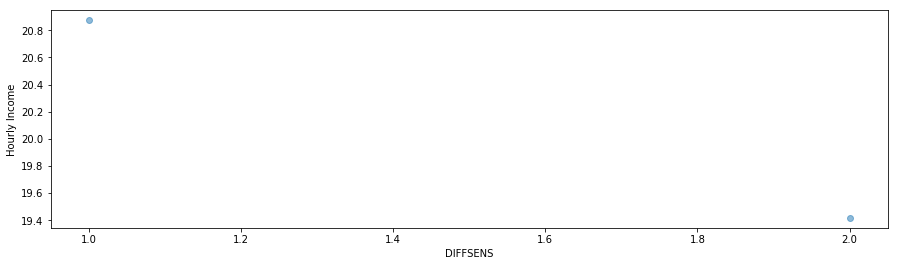

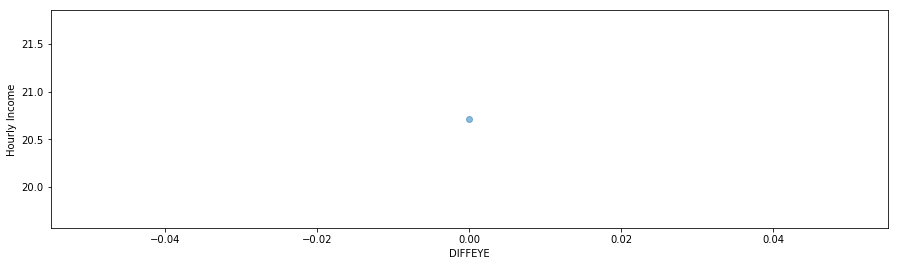

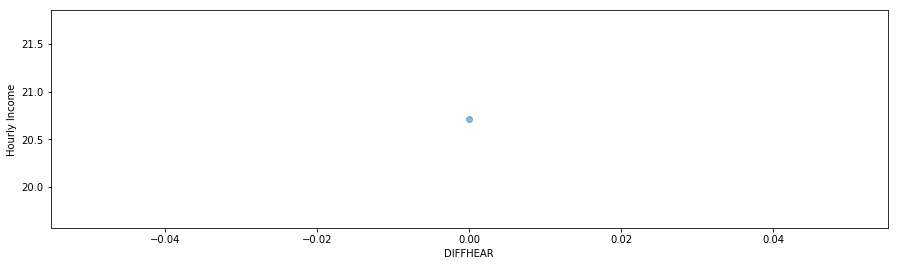

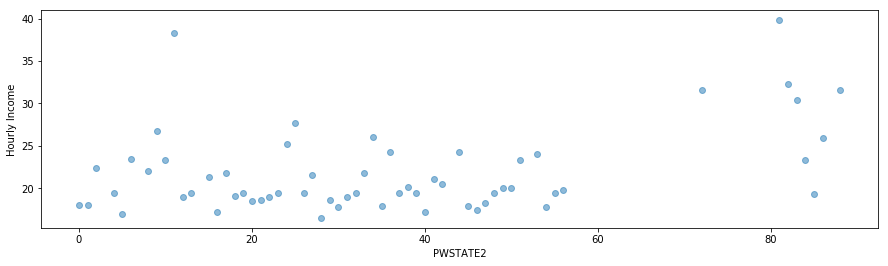

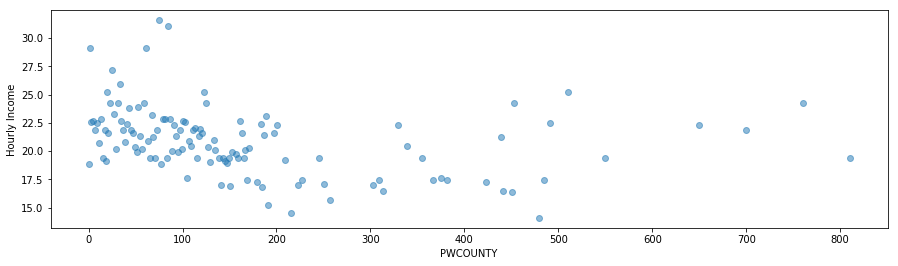

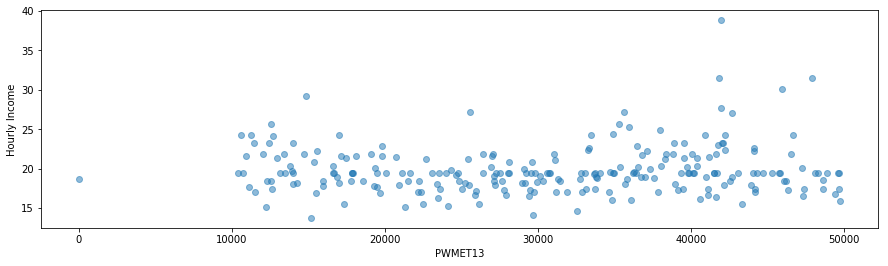

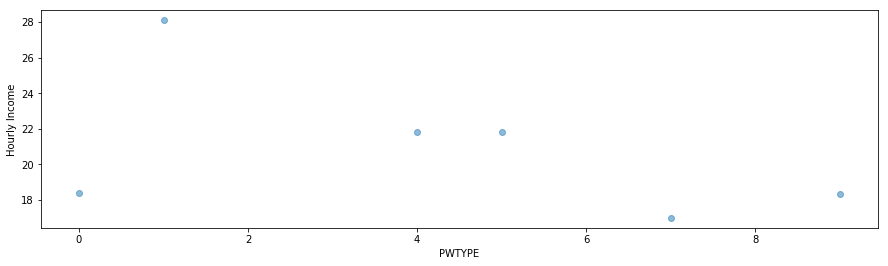

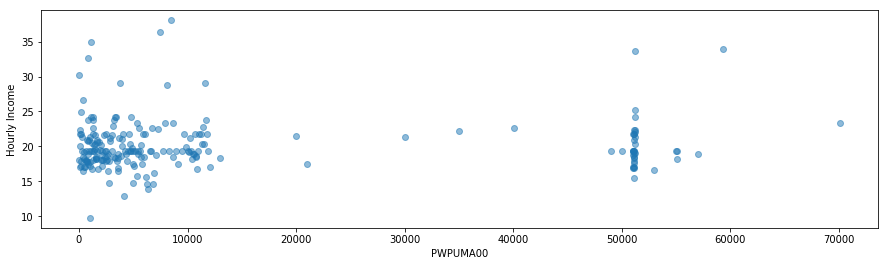

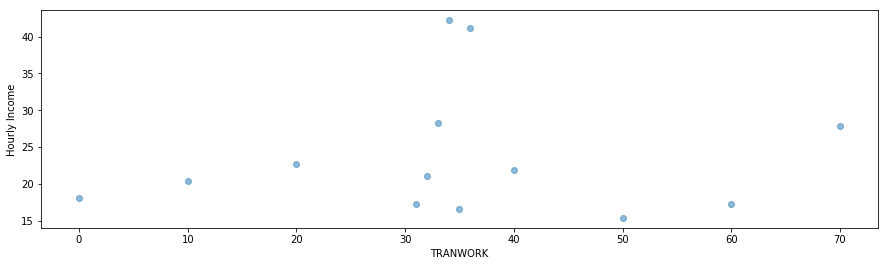

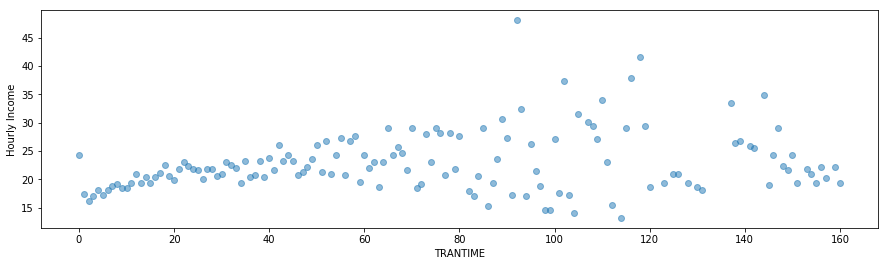

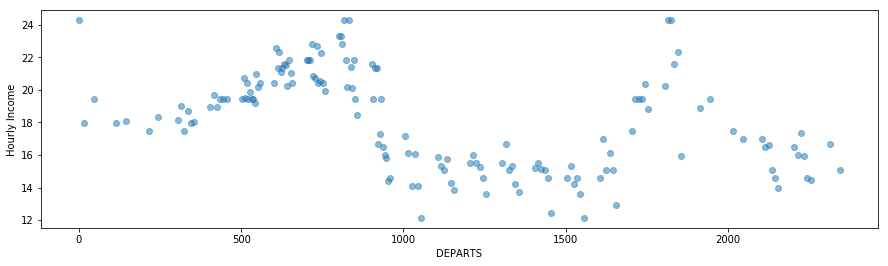

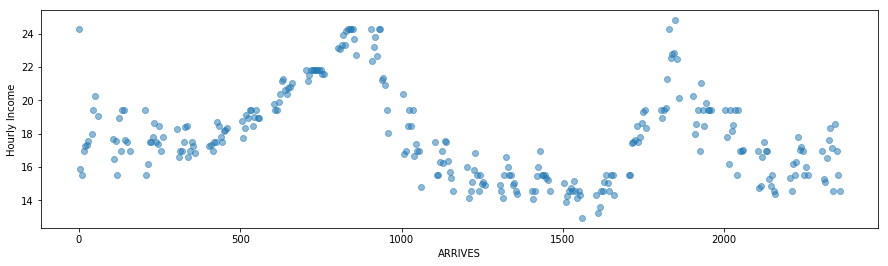

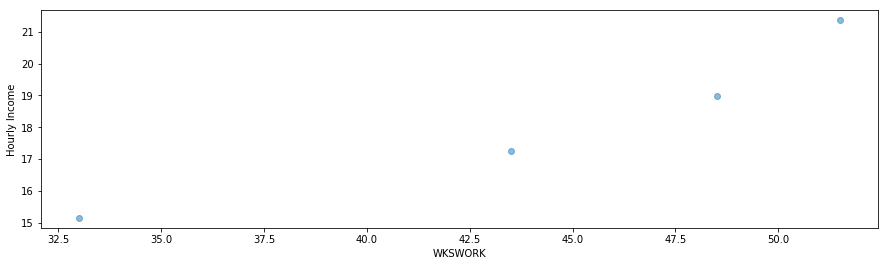

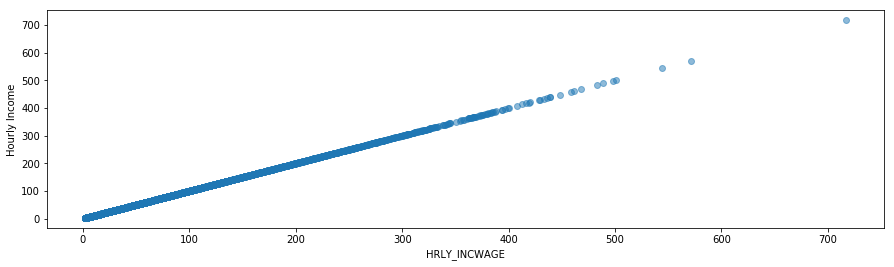

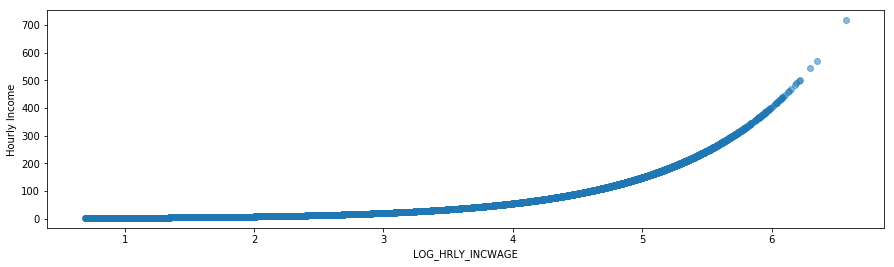

In [34]:
for i, col in enumerate(work_force.columns):
    fig, ax = plt.subplots(figsize=(15,4))
    grouped = work_force.groupby(col)
    mean_income_by_group = grouped['HRLY_INCWAGE'].median()
    plt.plot(mean_income_by_group, 'o', alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Hourly Income');
    plt.pause(0.05)

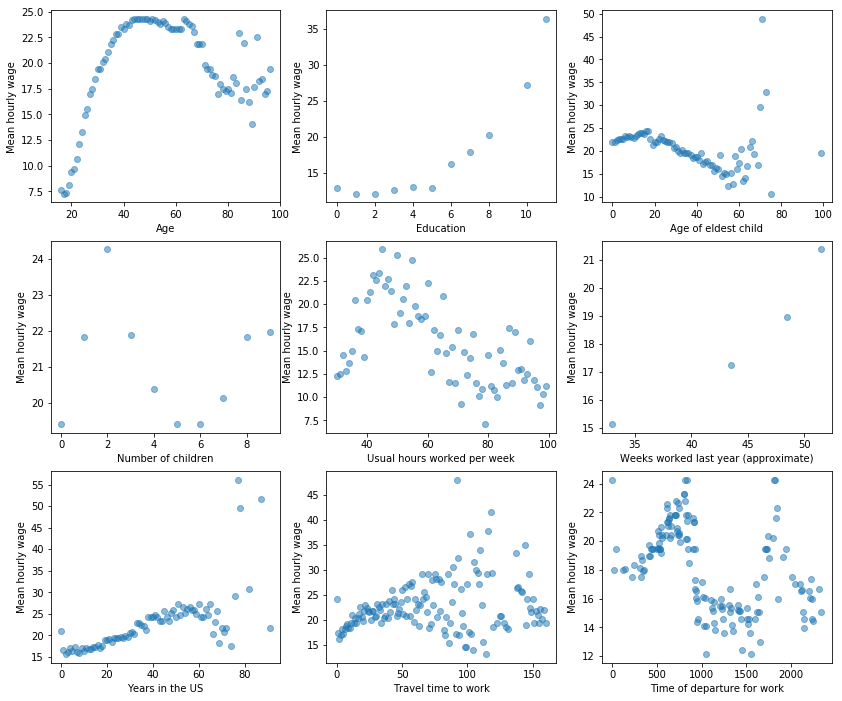

In [35]:
variables = ['AGE', 'EDUC', 'ELDCH','NCHILD', 'UHRSWORK', 'WKSWORK', 'YRSUSA1', 'TRANTIME', 'DEPARTS']
variables_describe = ['Age', 'Education', 'Age of eldest child', 'Number of children', 'Usual hours worked per week', 'Weeks worked last year (approximate)', 'Years in the US', 'Travel time to work', 'Time of departure for work']

fig, axarr = plt.subplots(3, 3, figsize=(14,12))
for i in range(3):
    for j in range(3):
        grouped = work_force.groupby(variables[i * 3 + j])
        mean_income_by_group = grouped['HRLY_INCWAGE'].median()
        axarr[i, j].plot(mean_income_by_group, 'o', alpha=0.5)
        axarr[i, j].set(ylabel='Mean hourly wage', xlabel=variables_describe[i * 3 + j])

In [36]:
work_force_pow4 = work_force.copy()
for var in variables:
    for power in '234':
        work_force_pow4[var+power] = work_force_pow4[var]**int(power)
        
work_force_pow4.head()

,HHWT,REGION,STATEFIP,COUNTYFIP,METRO,MET2013,CITY,CITYERR,PUMA,CPUMA0010,...,WKSWORK4,YRSUSA12,YRSUSA13,YRSUSA14,TRANTIME2,TRANTIME3,TRANTIME4,DEPARTS2,DEPARTS3,DEPARTS4
0,45,32,1,0,0,0,0,0,1800,13,...,7.034430e+06,0,0,0,2500,125000,6250000,412164,264609288,169879162896
1,136,32,1,0,0,0,0,0,2400,16,...,7.034430e+06,0,0,0,2025,91125,4100625,3258025,5880735125,10614726900625
2,19,32,1,0,0,0,0,0,2500,16,...,7.034430e+06,0,0,0,625,15625,390625,514089,368601813,264287499921
3,21,32,1,0,0,0,0,0,500,2,...,7.034430e+06,289,4913,83521,3600,216000,12960000,362404,218167208,131336659216
4,21,32,1,0,0,0,0,0,500,2,...,7.034430e+06,0,0,0,7225,614125,52200625,492804,345948408,242855782416


KeyboardInterrupt: 

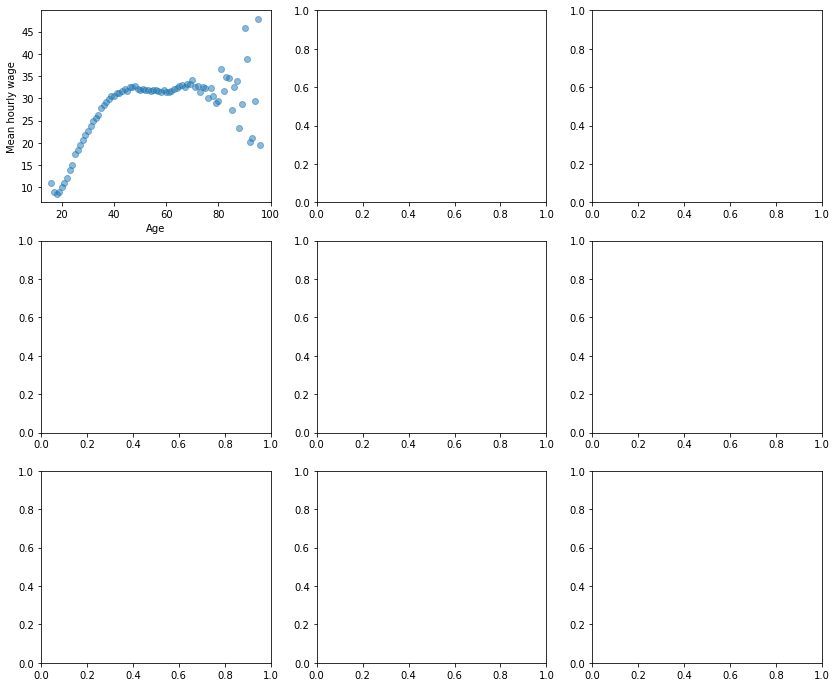

In [37]:
fig, axarr = plt.subplots(3, 3, figsize=(14,12))
for i in range(3):
    for j in range(3):
        col = variables[i * 3 + j]
        # Plot data
        grouped = work_force_pow4.groupby(col)
        mean_income_by_group = grouped['HRLY_INCWAGE'].mean()
        axarr[i, j].plot(mean_income_by_group, 'o', alpha=0.5, label='data')
        axarr[i, j].set(ylabel='Mean hourly wage', xlabel=variables_describe[i * 3 + j])
        
        # Plot predicted male and female
        formula = 'HRLY_INCWAGE ~ C(SEX) + '
        for name in variables:
            formula += col + ' + '
            formula += col + '2 + '
            formula += col + '3 + '
            formula += col + '4 + '
        model = smf.ols(formula[:-3], data=work_force_pow4)
        results = model.fit()
        
        df = pd.DataFrame()
        df[col] = np.linspace(work_force_pow4[col].min(), work_force_pow4[col].max(), len(work_force_pow4[col]))
        df[col+'2'] = df[col]**2
        df[col+'3'] = df[col]**3
        df[col+'4'] = df[col]**4
        
        df['SEX'] = 1
        pred = results.predict(df)
        axarr[i, j].plot(df[col], pred, label='male')
        
        df['SEX'] = 0
        pred = results.predict(df)
        axarr[i, j].plot(df[col], pred, label='female') 
        axarr[i, j].legend();

## People with Disabilities

1 = Does not have a disability

2 = Have a disability

In [ ]:
diff_vars = ['DIFFHEAR', 'DIFFPHYS', 'DIFFEYE', 'DIFFCARE', 'DIFFREM', 'DIFFMOB']
diff_vars_describe = ['Hearing difficulty', 'Ambulatory difficulty', 'Vision difficulty', 'Self-care difficulty', 'Cognitive difficulty', 'Independent living difficulty']
is_disabled = (work_force["DIFFHEAR"] == 2) | (work_force["DIFFEYE"] == 2) | (work_force["DIFFPHYS"] == 2) | (work_force["DIFFCARE"] == 2) | (work_force["DIFFMOB"] == 2) | (work_force["DIFFREM"] == 2)

First, we create a DataFrame for those respondents who do not have any disability. We also include the `HRLY_INCWAGE` column in this DataFrame.

In [ ]:
non_disabled = work_force[["HRLY_INCWAGE"] + diff_vars].copy()
non_disabled = non_disabled[~is_disabled]

non_disabled.head()

Next, we create a DataFrame to store the `HRLY_INCWAGE` of non-disabled people.

In [ ]:
diff_df = work_force[["CBSERIAL"]].copy() # CBSERIAL is a dummy variable to keep the index column
diff_df["No difficulties"] = non_disabled["HRLY_INCWAGE"]
diff_df.head()

Similarly, we also create a DataFrame for each group of disabled people and add them to `diff_df`.

In [ ]:
for i, col in enumerate(diff_vars):
    disabled = work_force.copy()
    disabled = disabled[disabled[col] == 2]
    # Add a column to diff_df
    diff_df[diff_vars_describe[i]] = disabled["HRLY_INCWAGE"]
    
# Drop the dummy variable
diff_df = diff_df.drop(["CBSERIAL"], axis=1)
diff_df.describe()

Finally, we plot the result using Box Plot.

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax = sns.boxplot(data=diff_df, orient="h", palette="Set2", showfliers=False)
ax.set(xlabel="Hourly income")

### Comparing incomes between men and women in non-disabled and disabled groups

We create a similar `non_disabled` DataFrame as above. This time, we also include the `SEX` column.

In [ ]:
work_force["DIFFTOTAL"] = is_disabled
non_disabled = work_force[["HRLY_INCWAGE", "SEX", "DIFFTOTAL"]]
non_disabled = non_disabled[~is_disabled]
    
non_disabled.head()

Next, we select people with at least one disability and keep two columns, `HRLY_INCWAGE` and `SEX`.

In [ ]:
disabled = work_force[["HRLY_INCWAGE", "SEX", "DIFFTOTAL"]]
disabled = disabled[is_disabled]
disabled.head()

First, let's look at the distribution of hourly income of the `non_disabled` group.

In [ ]:
hist_non_disabled = thinkstats2.Hist(np.round(non_disabled["HRLY_INCWAGE"]), label='non-disabled')
thinkplot.hist(hist_non_disabled)
thinkplot.Config(xlim=(0, 100), xlabel="Hourly income", ylabel="Count")

The distribution is highly skews, so we will use median income to compute the pay gap in each group, which we will use to analyze the effect of disability on pay gap.

For `non_disabled` group, we can compute the difference between median hourly income of men and of women as follows:

In [ ]:
male_median_non_disabled = non_disabled[non_disabled.SEX == 1]["HRLY_INCWAGE"].median()
female_median_non_disabled = non_disabled[non_disabled.SEX == 0]["HRLY_INCWAGE"].median()
pay_gap_non_disabled = male_median_non_disabled - female_median_non_disabled
print("Male median hourly income\t", male_median_non_disabled)
print("Female median hourly income\t", female_median_non_disabled)
print("Pay gap (Non-disabled)\t\t", pay_gap_non_disabled)

For `disabled` group:

In [ ]:
male_median_disabled = disabled[disabled.SEX == 1]["HRLY_INCWAGE"].median()
female_median_disabled = disabled[disabled.SEX == 0]["HRLY_INCWAGE"].median()
pay_gap_disabled = male_median_disabled - female_median_disabled
print("Male median hourly income\t", male_median_disabled)
print("Female median hourly income\t", female_median_disabled)
print("Pay gap (Disabled)\t\t", pay_gap_disabled)

Analysissss

In [ ]:
(pay_gap_non_disabled - pay_gap_disabled)/pay_gap_non_disabled

Compute CI.....

In [ ]:
def computePayGap(df):
        male_median = df[df.SEX == 1]["HRLY_INCWAGE"].median()
        female_median = df[df.SEX == 0]["HRLY_INCWAGE"].median()
        return male_median - female_median
    
def computeStatistic(df):
    df = df[["HRLY_INCWAGE", "SEX", "DIFFTOTAL"]]
    is_disabled = df["DIFFTOTAL"]
    
    non_disabled = df[~is_disabled]
    disabled = df[is_disabled]

    pay_gap_non_disabled = computePayGap(non_disabled)
    pay_gap_disabled = computePayGap(disabled)

    return (pay_gap_non_disabled - pay_gap_disabled)/pay_gap_non_disabled
    
def computeCI(work_force, iter=201):
    stats = []
    
    for i in range(iter):
        df = thinkstats2.ResampleRows(work_force)
        stat = computeStatistic(df)
        stats.append(stat)
    
    cdf = thinkstats2.Cdf(stats)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    return ci

In [ ]:
computeCI(work_force)

Compute P value

In [ ]:
class ProportionalTest():
    def __init__(self, data):
        self.data = data
        self.actual = self.TestStatistic(data)
        
    def PValue(self, iters=101):
        self.test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return 100 * count / iters
        
    def TestStatistic(self, data):
        return computeStatistic(data)

    def RunModel(self):
        # Copy the data frame
        shuffled_data = self.data.copy()
        # Permutate the rows of the DIFFTOTAL column on the copy
        shuffled_data["DIFFTOTAL"] = np.random.permutation(shuffled_data["DIFFTOTAL"]) 
        
        return shuffled_data

In [ ]:
ProportionalTest(work_force).PValue()